# Tutorial 1: Getting Started with SQuADDS

In this tutorial, we will walk you through some basic usage of SQuADDS. By the end of this tutorial, you will be able to:

- Have an HuggingFace account

- Access the SQuADDS Database

- Use the SQuADDS API to query for closest and "best-guess" interpolated device designs for your chosen Hamiltonian parameters

- Simulate the "best-guess" design using an EM solver tool

In [ ]:
! conda list | grep squadds

In [1]:
%load_ext autoreload
%autoreload 2

Since the SQuADDS Database is hosted on [HuggingFace](https://huggingface.co/), we will need to create an account and get an API key to access the database.

## HuggingFace 🤗 

HuggingFace is a company that provides a large number of NLP models and datasets. They also provide a platform to host your own models and datasets.

### Creating an  Account

Follow the instructions here - [HuggingFace: Sign Up](https://huggingface.co/join) - to create an account.

Once you have created an account, you can get your API key from the [settings page](https://huggingface.co/settings/token).

Please update the `HUGGINGFACE_API_KEY` variable in the `.env` file with your API key **OR** execute the following code to set the environment variable.

In [ ]:
from squadds.core.utils import set_huggingface_api_key

set_huggingface_api_key()

### Login

To login to your HuggingFace account, run the following command in your terminal:

```bash
huggingface-cli login
```



You will be prompted to enter your username and password. Once you have logged in, you can check your login status by running the following command:

```bash
huggingface-cli whoami
```

### Accessing the SQuADDS Database using the HuggingFace API

The SQuADDS Database is hosted on HuggingFace. You can access the database using the `datasets` library from HuggingFace.

In [ ]:
from datasets import get_dataset_config_names
from datasets import load_dataset

configs = get_dataset_config_names("SQuADDS/SQuADDS_DB")

You can navigate the database using HuggingFace API. For example, you can access the qubit database using the following code:

In [ ]:
qubit_data = load_dataset("SQuADDS/SQuADDS_DB", configs[0])

In [ ]:
qubit_data

Each configuration in the dataset is uniquely identified by their `config`. For the SQuADDS Database, the `config` string is created in the following format:

```python
config = f"{component}_{component_name}_{data_type}"
```

where `component` is the name of the component, `component_name` is the name of the component (in Qiskit Metal), and `data_type` is the type of simulation data that has been contributed.

Lets check what the `config` string looks like for our database:

In [ ]:
components = []
component_names = []
data_types = []

for config in configs:
    components.append(config.split("-")[0])
    component_names.append(config.split("-")[1])
    data_types.append(config.split("-")[2])
    
print(components)
print(component_names)
print(data_types)
    

## Using the SQuADDS API to access and anlyze the database

While it is possible to directly access the SQuADDS Database using the `datasets` library, we have created a simple API to make it easier to query the database.

The main object we use to access the database is the `SQuADDS_DB` class. 

In [2]:
from squadds import SQuADDS_DB

db = SQuADDS_DB()

DotNet Core correctly loaded.


You can get a summary of the datasets by running.

In [ ]:
db.view_datasets()

To check for the `config` names

In [ ]:
db.get_configs()

If you are interested to learn more about each configuration, you can do so by using the `get_dataset_info` method.


In [ ]:
db.get_dataset_info(component="qubit", component_name="TransmonCross", data_type="cap_matrix")

In [ ]:
db.get_dataset_info(component="cavity_claw", component_name="RouteMeander", data_type="eigenmode")

You can get the entire dataset as a Pandas DataFrame by using the `get_dataset` method.

In [ ]:
db.see_dataset(component="qubit", component_name="TransmonCross", data_type="cap_matrix")

If you want to learn about the who contributed the data, you can use the following methods:

In [ ]:
db.view_contributors_of("qubit", "TransmonCross", "cap_matrix")

In [ ]:
db.view_all_contributors()

As the SQuADDS_DB dataset updates, so will all the information we have queried automatically. 

## Making Systems out of Circuit QED Elements

One of the main use cases of the SQuADDS project is to get the design space parameters for systems of our interest using our desired Hamiltonian parameters.

Using the SQuADDS API, we can "build" a system by choosing the circuit QED components we want to use.

The following subsections walks you through some examples.

### Querying for the a target qubit design

Let's say you know the Hamiltonian parameters of a qubit you want to use. You can use the SQuADDS API to query for the closest design to your target qubit.

We first need to select our sytem of interest.

In [ ]:
db.select_system("qubit")

Now, we need to specify to SQuADDS what type of `qubit` our system is. We can do this by using the `select_qubit` method.

In [ ]:
db.select_qubit("TransmonCross")

We now create the system dataframe so that we can query for the design parameters we are interested in.

In [ ]:
df = db.create_system_df()
df

Now that we have created our system dataframe, we can query for the closest design to our target qubit parameters. To do this we need to call the `Analyzer` object.

In [ ]:
from squadds import Analyzer

We instatantaite the `Analyzer` object by passing in the `SQuADDS_DB` instance we created earlier.

In [ ]:
analyzer = Analyzer(db)

We can now check for what type of Hamiltonian parameters are available for our chosen system

In [ ]:
analyzer.target_param_keys()

Now, Let's select a geometry which results in the closest qubit characteristics

Call `Analyzer.find_closest`

**Documentation:**

```
Finds the rows in the DataFrame with the closest matching characteristics
to the given target parameters using a specified metric.

Args:
    target_params (dict): A dictionary containing the target values for columns in `self.df`.
                          Keys are column names and values are the target values.
    num_top (int): The number of closest matching rows to return.
    metric (str, optional): The distance metric to use for finding the closest matches.
                            Available options are specified in `self.__supported_metrics__`.
                            Defaults to 'Euclidean'.
    display (bool, optional): Whether to display warnings and logs. Defaults to True.

Returns:
    pd.DataFrame: A DataFrame containing the rows with the closest matching characteristics,
                  sorted by the distance metric.

Raises:
    ValueError: If the specified metric is not supported or `num_top` exceeds the DataFrame size.
```

You are given the choice of the following metrics.

In [ ]:
analyzer.__supported_metrics__

Define your Hamiltonian parameters that you want to use for your qubit 

In [ ]:
target_params={"qubit_frequency_GHz": 4, "anharmonicity_MHz": -200}

In [ ]:
results = analyzer.find_closest(target_params=target_params,
                                       num_top=3,
                                       metric="Euclidean",
                                       display=True)
results

Thats it! You have now found some designs for your qubit that are closest to your target Hamiltonian parameters.

#### Using Custom Metrics

To use a custom metric first define the function. For example, lets say we want the manhattan metric

In [ ]:
def manhattan_distance(target, simulated):
    return sum(abs(target[key] - simulated.get(key, 0)) for key in target)

In [ ]:
analyzer.custom_metric_func = manhattan_distance

In [ ]:
analyzer.find_closest(target_params=target_params,
                                            num_top=1,
                                            metric="Custom",
                                            display=True)

In [ ]:
best_options = results.iloc[0]["design_options"]
best_options

You can pass in the `design_options` from the closest design to the `options` argument of your selected qubit and render it in qiskit metal.

In [ ]:
# Qiskit Metal imports
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict
from qiskit_metal.designs.design_multiplanar import MultiPlanar

from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.core import QRoute, QRoutePoint

In [ ]:
design = MultiPlanar(metadata={},
                     overwrite_enabled=True)
gui = MetalGUI(design)

In [ ]:
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross

TransmonCross(design, "transmon", options=best_options)

gui.rebuild()
gui.zoom_on_components(['transmon'])
gui.screenshot("qubit_only.png")

### Querying for a target cavity design

The same workflow can be used to query for a target cavity design.

While it is not necessary, it may be a good idea to `unselect_all()` before creating a new system.

In [ ]:
db.unselect_all()

Proceed with selecting the system of interest

In [3]:
db.select_system("cavity_claw")

In [4]:
db.select_cavity_claw("RouteMeander")

In [5]:
db.select_coupler("CLT")

It's always a good idea to check that the system you have selected is correct.

In [ ]:
db.show_selections()

Great! lets create the system dataframe and analyze it.

In [ ]:
df = db.create_system_df()

In [ ]:
analyzer = Analyzer(db)

In [ ]:
analyzer.target_param_keys()

Select the Hamiltonian parameters you want to use for your cavity and search for the closest designs.

In [ ]:
target_params = {"cavity_frequency_GHz": 6.9,
                "kappa_kHz": 120,
                "resonator_type":"quarter"}

In [ ]:
results = analyzer.find_closest(target_params=target_params,
                                       num_top=5,
                                       metric="Euclidean",
                                       display=True)
results

Similarly, if we wanted a `half`-wave resonator (i.e. has an `NCap` coupling to the feedline), we can do the following:

In [ ]:
db.unselect_all()

db.select_system("cavity_claw")
db.select_cavity_claw("RouteMeander")
db.select_coupler("NCap")

In [ ]:
df = db.create_system_df()

In [ ]:
analyzer = Analyzer(db)

In [ ]:
target_params = {"cavity_frequency_GHz": 6.9,
                "kappa_kHz": 120,
                "resonator_type":"half"}

In [6]:
cavity_df = db.get_dataset(data_type="eigenmode", component="cavity_claw", component_name="RouteMeander")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
cavity_df = cavity_df[cavity_df["coupler_type"] == "NCap"]

In [8]:
ncap_df = db.get_dataset(data_type="cap_matrix", component="coupler", component_name="NCap") #TODO: handle dynamically

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
ncap_df

In [2]:
from squadds.core.processing import *

DotNet Core correctly loaded.


In [3]:
merger_terms = ['prime_width', 'prime_gap'] 
ncap_sim_cols = ['bottom_to_bottom', 'bottom_to_ground', 'ground_to_ground',
            'top_to_bottom', 'top_to_ground', 'top_to_top', "units"]

In [4]:
merged_df_old = update_ncap_parameters(cavity_df, ncap_df, merger_terms, ncap_sim_cols)

NameError: name 'cavity_df' is not defined

In [ ]:
freqs_old, kappa_old = merged_df_old["cavity_frequency"].values, merged_df_old["kappa"].values

In [ ]:
merged_df_dev = update_ncap_parameters(cavity_df, ncap_df, merger_terms, ncap_sim_cols)

In [ ]:
freqs_dev, kappa_dev = merged_df_dev["cavity_frequency"].values, merged_df_dev["kappa"].values

In [ ]:
merged_df_dev.columns

In [23]:
qubit_df = db.get_dataset(data_type="cap_matrix", component="qubit", component_name="TransmonCross") #TODO: handle dynamically

In [24]:
# only include the first 100 rows for the sake of the example
merged_df_old = merged_df_old.iloc[:100]

In [26]:
df = db.create_qubit_cavity_df(qubit_df, cavity_df, merger_terms=['claw_width', 'claw_length', 'claw_gap'])

In [27]:
df.columns

Index(['PI_qubit', 'date_created_qubit', 'group_qubit', 'institution_qubit',
       'uploader_qubit', 'design_options_qubit', 'design_tool_qubit',
       'claw_to_claw', 'claw_to_ground', 'cross_to_claw', 'cross_to_cross',
       'cross_to_ground', 'ground_to_ground', 'units_qubit',
       'renderer_options_qubit', 'setup_qubit', 'simulator_qubit',
       'PI_cavity_claw', 'date_created_cavity_claw', 'group_cavity_claw',
       'institution_cavity_claw', 'misc', 'uploader_cavity_claw',
       'coupler_type', 'design_options_cavity_claw', 'design_tool_cavity_claw',
       'resonator_type', 'cavity_frequency', 'kappa', 'units_cavity_claw',
       'renderer_options_cavity_claw', 'setup_cavity_claw',
       'simulator_cavity_claw', 'temp_prime_width', 'temp_prime_gap',
       'design_options'],
      dtype='object')

In [39]:
df_dev = create_qubit_cavity_df(qubit_df, merged_df_old, merger_terms=['claw_width', 'claw_length', 'claw_gap'])

In [ ]:
best_device_design_ncap = df.iloc[0]["design_options"]

In [ ]:
from squadds.components.coupled_systems import QubitCavity
import qiskit_metal as metal
from qiskit_metal import Dict, MetalGUI, designs, draw
from qiskit_metal.toolbox_metal import math_and_overrides

design = metal.designs.design_planar.DesignPlanar()
gui = metal.MetalGUI(design)
design.overwrite_enabled = True

qc_ncap = QubitCavity(design, "qubit_cavity", options=best_device_design_ncap)
gui.rebuild()
gui.autoscale()
gui.screenshot()

In [5]:
from squadds import SQuADDS_DB
from squadds import Analyzer


db = SQuADDS_DB()

db.select_system(["qubit","cavity_claw"])
db.select_qubit("TransmonCross")
db.select_cavity_claw("RouteMeander")
db.select_coupler("NCap")
merged_df = db.create_system_df()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
target_params = {
                "qubit_frequency_GHz": 4,
                "cavity_frequency_GHz": 6.2,
                "kappa_kHz": 120,
                "resonator_type":"half",
                "anharmonicity_MHz": -200,
                "g_MHz": 70}

analyzer = Analyzer(db)
results = analyzer.find_closest(target_params=target_params,
                                       num_top=1,
                                       metric="Euclidean")

In [7]:
best_device = results.iloc[0]
best_device_design_ncap = best_device["design_options"]
best_device_design_ncap

{'cavity_claw_options': {'coupler_type': 'NCap',
  'coupler_options': {'cap_distance': '50.9um',
   'cap_gap': '5um',
   'cap_gap_ground': '5.1um',
   'cap_width': '10um',
   'coupling_length': None,
   'coupling_space': None,
   'down_length': None,
   'finger_count': '5',
   'finger_length': '30um',
   'open_termination': None,
   'orientation': '-90',
   'prime_gap': '5.1um',
   'prime_width': '11.7um',
   'second_gap': '5.1um',
   'second_width': '11.7um'},
  'cpw_opts': {'left_options': {'fillet': '49.9um',
    'lead': {'end_straight': '50um',
     'start_jogged_extension': None,
     'start_straight': '100um'},
    'meander': {'asymmetry': None, 'spacing': '100um'},
    'pin_inputs': {'end_pin': {'component': 'claw', 'pin': 'readout'},
     'start_pin': {'component': 'cplr', 'pin': 'second_end'}},
    'total_length': '4200um',
    'trace_gap': '5.1um',
    'trace_width': '11.7um'}}},
 'qubit_options': {'aedt_hfss_capacitance': 0,
  'aedt_hfss_inductance': 9.686e-09,
  'aedt_q3d_c

11:21PM 29s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  WARNING: Layer-backing can not be explicitly controlled on 10.14 when built against the 10.14 SDK

11:21PM 30s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: <QNSWindow: 0x7f7be0dad0f0; contentView=<QNSView: 0x7f7be0dac9b0; QCocoaWindow(0x7f7be0dac890, window=QWidgetWindow(0x7f7be0dac410, name="MainWindowPlotWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.

11:21PM 30s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: <QNSWindow: 0x7f7be0dd52c0; contentView=<QNSView: 0x7f7be0dd4b80; QCocoaWindow(0x7f7be0dd4a60, window=QWidgetWindow(0x7f7be0dd45a0, name="ElementsWindowWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and w

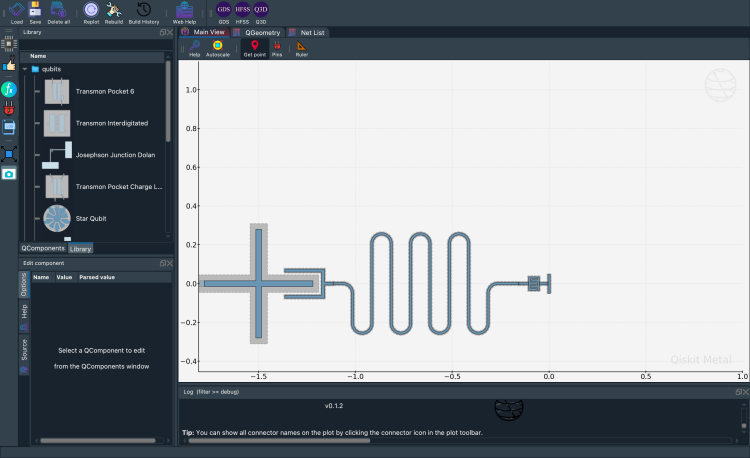

: 

In [8]:
from squadds.components.coupled_systems import QubitCavity
import qiskit_metal as metal
from qiskit_metal import Dict, MetalGUI, designs, draw
from qiskit_metal.toolbox_metal import math_and_overrides

design = metal.designs.design_planar.DesignPlanar()
gui = metal.MetalGUI(design)
design.overwrite_enabled = True

qc_ncap = QubitCavity(design, "qubit_cavity2", options=best_device_design_ncap)
gui.rebuild()
gui.autoscale()
gui.screenshot()

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(freqs_old/freqs_dev, label="Frequency")
plt.show()

In [ ]:
plt.plot(kappa_old/kappa_dev, label="Kappa")
plt.show()

In [ ]:
plt.hist(kappa_dev*1e-6,bins=100,range=(0,200))
plt.show()

In [ ]:
results = analyzer.find_closest(target_params=target_params,
                                       num_top=5,
                                       metric="Euclidean",
                                       display=True)
results

Lets say we want to use the "Weighted Euclidean" metric to find the closest design to our target cavity parameters.

#### Weighted Euclidean Metric

You can do a weighted Euclidean metric instead.

$$
F(\{P_i\},\{p_i\}) = \sum_i w_i\frac{(P_i - p_i)^2}{P_i^2}
$$

Here \( w_i \) are weights which default to 1 if not user-defined.

Note: The default metric for `find_closest` is `Euclidean` when not user-defined.


In [ ]:
# Set up the weights
analyzer.metric_weights = {"cavity_frequency_GHz": 2, "kappa_kHz": 1}

In [ ]:
results = analyzer.find_closest(target_params=target_params,
                                       num_top=3,
                                       metric="Weighted Euclidean",
                                       display=True)
results

### Querying for a target qubit-cavity design

Again, we follow the same procedure as before.

In [ ]:
db.select_system(["qubit","cavity_claw"])

In [ ]:
db.select_qubit("TransmonCross")
db.select_cavity_claw("RouteMeander")
db.select_coupler("CLT")

In [ ]:
db.show_selections()

In [ ]:
merged_df = db.create_system_df()

In [ ]:
merged_df

Pass the `SQuADDS_DB` instance to the `Analyzer` object.

In [ ]:
analyzer = Analyzer(db)

Always good to check whether the system you have selected is correct.

In [ ]:
db.selected_system

In [ ]:
analyzer.selected_system

Define the `target_params` for your qubit-cavity system.

In [ ]:
target_params = {
                "qubit_frequency_GHz": 4,
                "cavity_frequency_GHz": 6.2,
                "kappa_kHz": 120,
                "resonator_type":"quarter",
                "anharmonicity_MHz": -200,
                "g_MHz": 70}

In [ ]:
results = analyzer.find_closest(target_params=target_params,
                                       num_top=3,
                                       metric="Euclidean",
                                       display=True)
results

Awesome! we have some designs for our qubit-cavity system. To see where the closest design lies in the Hamiltonian parameter space, we can use the `closest_design_in_H_space` method.

In [ ]:
%matplotlib inline

In [ ]:
analyzer.closest_design_in_H_space()

#### Interpolation of Best Designs

Even though the `closest_design` will become better as more validated pre-simulated points are added to the database, it is still a good idea to interpolate to get the best designs.

We use the physics inspired interpolation algorithm described in our [paper](https://arxiv.org/pdf/2312.13483.pdf) - `ScalingInterpolator` class to interpolate the best designs.

In [ ]:
from squadds.interpolations.physics import ScalingInterpolator

We pass the `Analzyer` object and the `target_params` dict to the `ScalingInterpolator` class.

In [ ]:
# Create an instance of ScalingInterpolator
interpolator = ScalingInterpolator(analyzer, target_params)

design_df = interpolator.get_design()

The `design_df` contains the various `design_options` for the best designs and also the `sim_options` needed to simulate them.

In [ ]:
design_df

Congrats for making it to the end of this tutorial! 🤗🎉 You have now learned how to use the SQuADDS API to query for closest and "best-guess" interpolated device designs for your chosen Hamiltonian parameters.

## Next Steps...

In the next [tutorial](https://lfl-lab.github.io/SQuADDS/source/tutorials/Tutorial-2_Simulate_interpolated_designs.html), we will learn how to simulate the "best-guess" design using an EM solver tool and the `SQuADDS` API.

## License

<div style='width: 100%; background-color:#3cb1c2;color:#324344;padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>
    <h3>This code is a part of SQuADDS</h3>
    <p>Developed by Sadman Ahmed Shanto</p>
    <p>&copy; Copyright Sadman Ahmed Shanto & Eli Levenson-Falk 2023.</p>
    <p>This code is licensed under the MIT License. You may<br> obtain a copy of this license in the LICENSE.txt file in the root directory<br> of this source tree.</p>
    <p>Any modifications or derivative works of this code must retain this<br>copyright notice, and modified files need to carry a notice indicating<br>that they have been altered from the originals.</p>
</div>